Pixel Intensity-Based Regional Analysis (v5)

1. Loading images...
   Image shape: (4713, 3817)
   ROI shape:   (471, 382)

2. Extracting ROI regions...
   PVN: 1,200,810 px | MD: 679,100 px | RE: 1,576,869 px

3. Finding region components...
   PVN-1: center=(1296, 1881), area=1,200,810.0 px
   MD-1: center=(1857, 1174), area=368,300.0 px
   MD-2: center=(1734, 2658), area=310,800.0 px
   RE-1: center=(3594, 1906), area=1,576,869.0 px

4. Extracting intensities...


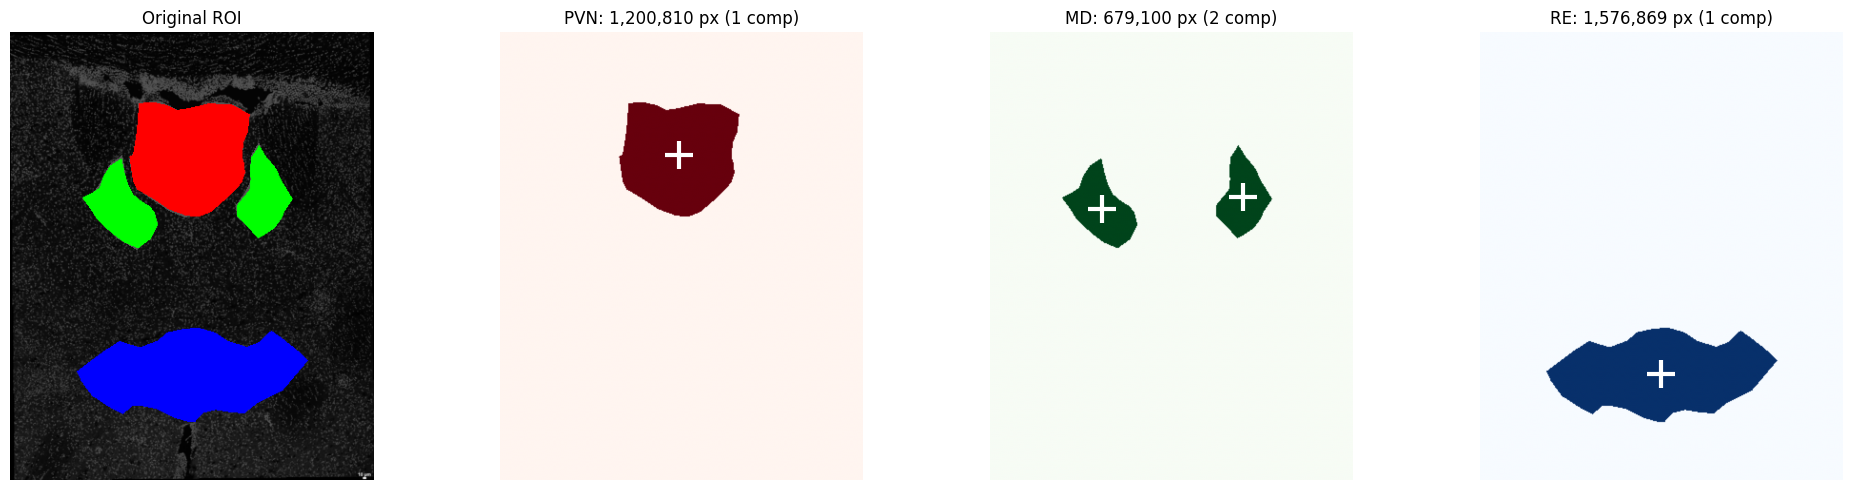


✓ Ready! Run: display(widgets.HBox([controls, out]))


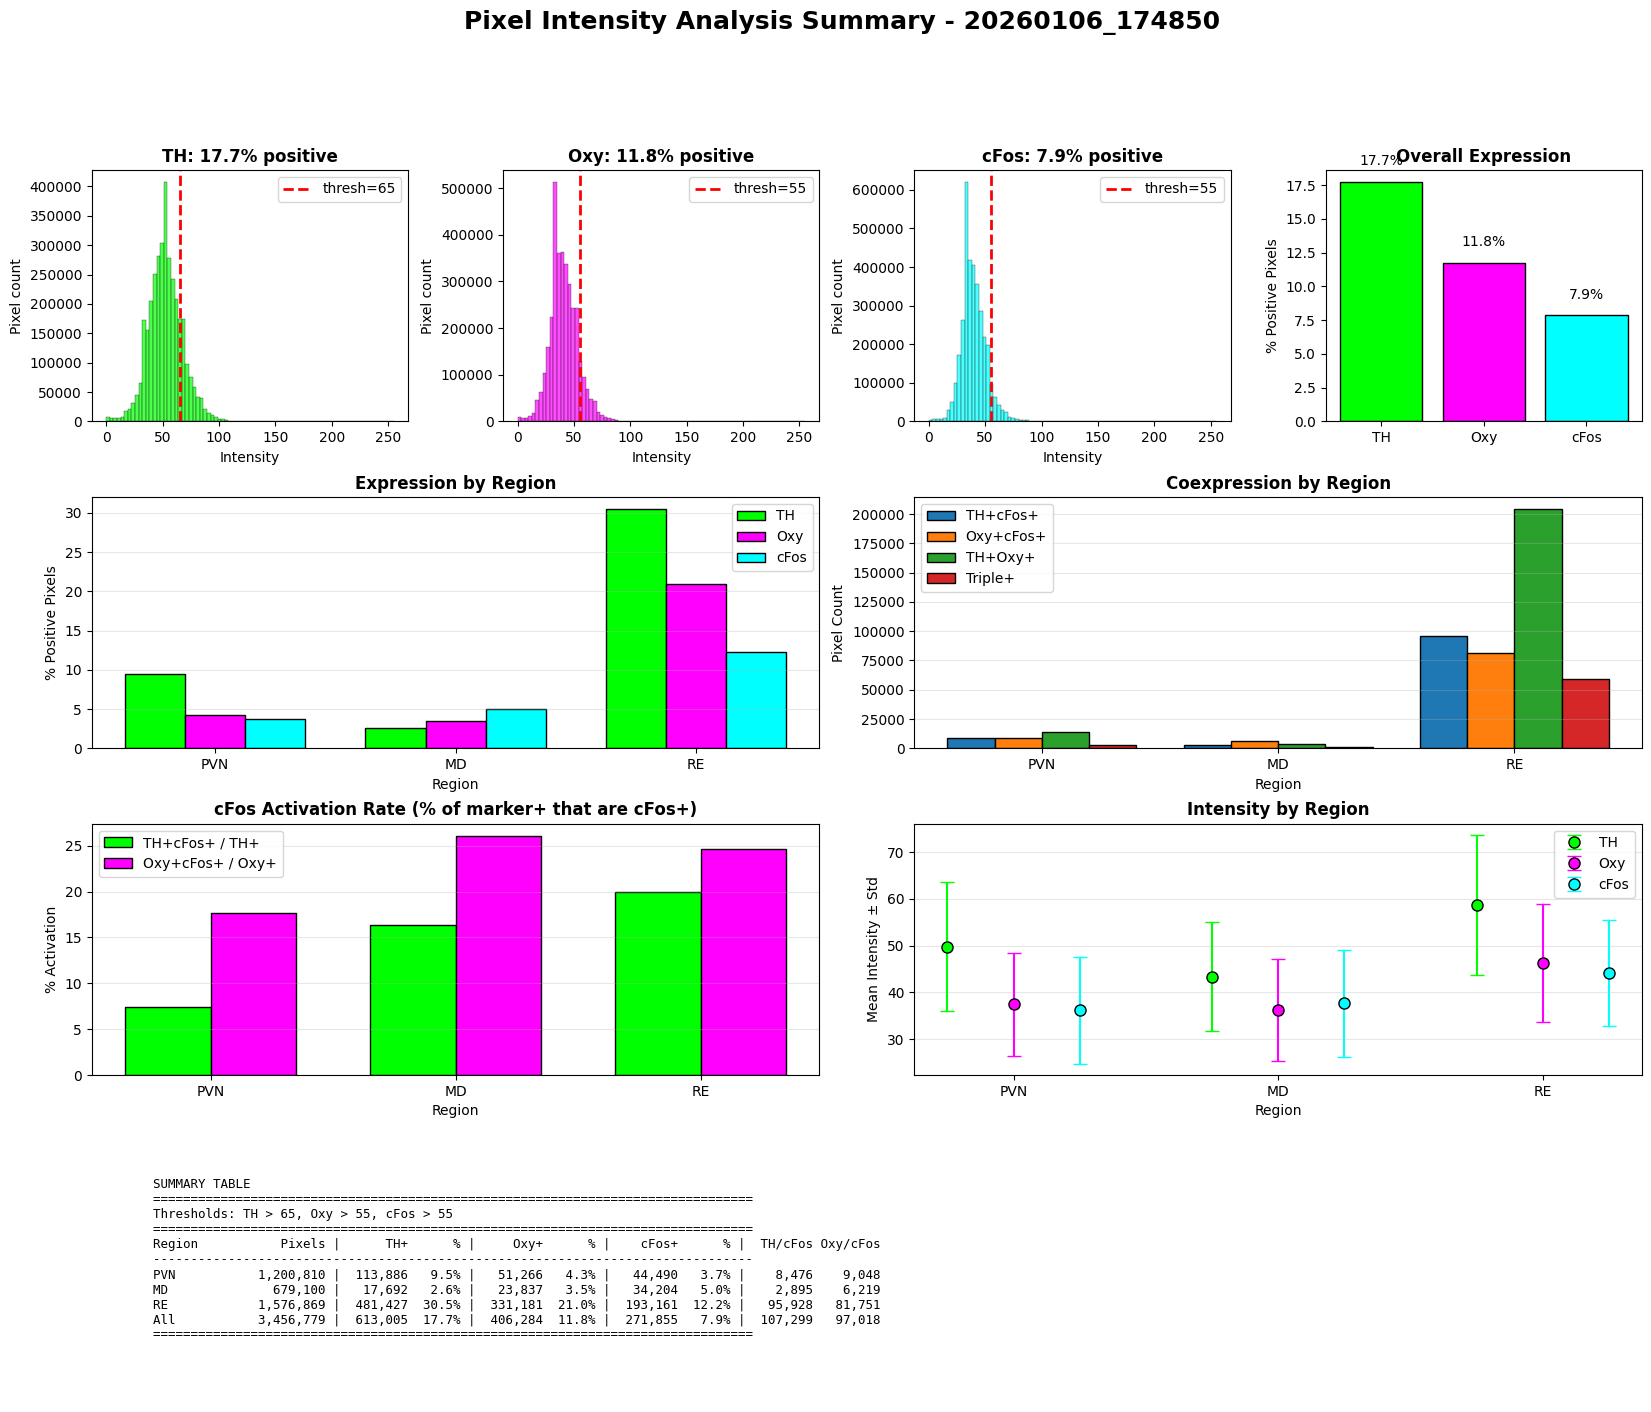

In [ ]:
"""
Pixel Intensity-Based Regional Analysis (v5)
=============================================
- V2-style clean layout
- Connected components for split regions (MD fix)
- Added detailed zoom views
"""

import ipywidgets as widgets
from IPython.display import display, clear_output
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from datetime import datetime
from skimage.transform import resize
from skimage.measure import label, regionprops
import matplotlib.patches as patches

# =============================================================================
# CONFIGURATION - UPDATE THESE PATHS
# =============================================================================
DAPI_PATH = 'PVN, MD, RE image61_R 91_Merged_ch00_SV.tif'
TH_PATH = 'PVN, MD, RE image61_R 91_Merged_ch01_SV.tif'
OXY_PATH = 'PVN, MD, RE image61_R 91_Merged_ch02_SV.tif'
CFOS_PATH = 'PVN, MD, RE image61_R 91_Merged_ch03_SV.tif'
ROI_PATH = 'ch00-1_new.png'

# =============================================================================
# LOAD DATA
# =============================================================================
print("="*60)
print("Pixel Intensity-Based Regional Analysis (v5)")
print("="*60)

print("\n1. Loading images...")
dapi_rgb = io.imread(DAPI_PATH)
th_rgb = io.imread(TH_PATH)
oxy_rgb = io.imread(OXY_PATH)
cfos_rgb = io.imread(CFOS_PATH)
roi_img = io.imread(ROI_PATH)

dapi = dapi_rgb[..., 2]
th = th_rgb[..., 1]
oxy = oxy_rgb[..., 0]
cfos = cfos_rgb[..., 0]

print(f"   Image shape: {dapi.shape}")
print(f"   ROI shape:   {roi_img.shape[:2]}")

# =============================================================================
# EXTRACT ROI REGIONS
# =============================================================================
print("\n2. Extracting ROI regions...")

r, g, b = roi_img[..., 0], roi_img[..., 1], roi_img[..., 2]

roi_mask_red = (r > g + 20) & (r > b + 20) & (r > 80)
roi_mask_green = (g > r + 20) & (g > b + 20) & (g > 80)
roi_mask_blue = (b > r + 20) & (b > g + 20) & (b > 80)

needs_resize = (roi_img.shape[0] != dapi.shape[0]) or (roi_img.shape[1] != dapi.shape[1])

if needs_resize:
    mask_pvn = resize(roi_mask_red.astype(float), dapi.shape, order=0, preserve_range=True) > 0.5
    mask_md = resize(roi_mask_green.astype(float), dapi.shape, order=0, preserve_range=True) > 0.5
    mask_re = resize(roi_mask_blue.astype(float), dapi.shape, order=0, preserve_range=True) > 0.5
else:
    mask_pvn = roi_mask_red
    mask_md = roi_mask_green
    mask_re = roi_mask_blue

print(f"   PVN: {mask_pvn.sum():,} px | MD: {mask_md.sum():,} px | RE: {mask_re.sum():,} px")

# =============================================================================
# FIND CONNECTED COMPONENTS
# =============================================================================
print("\n3. Finding region components...")

def get_region_components(mask, name):
    labeled = label(mask)
    props = sorted(regionprops(labeled), key=lambda x: x.area, reverse=True)
    components = []
    for i, prop in enumerate(props):
        cy, cx = int(prop.centroid[0]), int(prop.centroid[1])
        components.append({'center': (cy, cx), 'area': prop.area, 'bbox': prop.bbox})
        print(f"   {name}-{i+1}: center=({cy}, {cx}), area={prop.area:,} px")
    return components

region_components = {
    'PVN': get_region_components(mask_pvn, 'PVN'),
    'MD': get_region_components(mask_md, 'MD'),
    'RE': get_region_components(mask_re, 'RE')
}

# =============================================================================
# EXTRACT INTENSITIES
# =============================================================================
print("\n4. Extracting intensities...")

mask_all = mask_pvn | mask_md | mask_re
intensities = {}
REGION_ORDER = []

for name, mask in [('PVN', mask_pvn), ('MD', mask_md), ('RE', mask_re)]:
    if mask.sum() > 0:
        intensities[name] = {'TH': th[mask], 'Oxy': oxy[mask], 'cFos': cfos[mask]}
        REGION_ORDER.append(name)

intensities['All'] = {'TH': th[mask_all], 'Oxy': oxy[mask_all], 'cFos': cfos[mask_all]}

# =============================================================================
# DISPLAY SETUP
# =============================================================================
scale_display = 4
dapi_small = dapi[::scale_display, ::scale_display]
th_small = th[::scale_display, ::scale_display]
oxy_small = oxy[::scale_display, ::scale_display]
cfos_small = cfos[::scale_display, ::scale_display]
mask_pvn_small = mask_pvn[::scale_display, ::scale_display]
mask_md_small = mask_md[::scale_display, ::scale_display]
mask_re_small = mask_re[::scale_display, ::scale_display]

MARKER_COLORS = {'TH': '#00FF00', 'Oxy': '#FF00FF', 'cFos': '#00FFFF'}
REGION_COLORS = {'PVN': '#FF4444', 'MD': '#44FF44', 'RE': '#4444FF', 'All': '#AAAAAA'}

mask_dict_full = {'PVN': mask_pvn, 'MD': mask_md, 'RE': mask_re}
mask_dict_small = {'PVN': mask_pvn_small, 'MD': mask_md_small, 'RE': mask_re_small}
img_dict_full = {'TH': th, 'Oxy': oxy, 'cFos': cfos}
img_dict_small = {'TH': th_small, 'Oxy': oxy_small, 'cFos': cfos_small}

current_state = {}

# =============================================================================
# DEBUG VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(roi_img)
axes[0].set_title('Original ROI')

for ax, (name, mask, cmap) in zip(axes[1:], 
    [('PVN', mask_pvn, 'Reds'), ('MD', mask_md, 'Greens'), ('RE', mask_re, 'Blues')]):
    ax.imshow(mask, cmap=cmap)
    for comp in region_components[name]:
        cy, cx = comp['center']
        ax.plot(cx, cy, 'w+', markersize=20, markeredgewidth=3)
    ax.set_title(f'{name}: {mask.sum():,} px ({len(region_components[name])} comp)')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.savefig('roi_debug_v5.png', dpi=150)
plt.show()

# =============================================================================
# UPDATE FUNCTION
# =============================================================================
def update_display(th_thresh, oxy_thresh, cfos_thresh, show_marker, zoom_pad):
    clear_output(wait=True)
    
    current_state.update({
        'th_thresh': th_thresh, 'oxy_thresh': oxy_thresh, 'cfos_thresh': cfos_thresh
    })
    
    thresh_dict = {'TH': th_thresh, 'Oxy': oxy_thresh, 'cFos': cfos_thresh}
    
    # =========================================================================
    # FIGURE 1: Histograms (V2 style - 3 rows x 4 cols)
    # =========================================================================
    fig1, axes1 = plt.subplots(3, 4, figsize=(18, 10))
    fig1.suptitle('Intensity Distributions by Region', fontsize=16, fontweight='bold')
    
    for row, marker in enumerate(['TH', 'Oxy', 'cFos']):
        thresh = thresh_dict[marker]
        color = MARKER_COLORS[marker]
        
        for col, region in enumerate(REGION_ORDER + ['All']):
            ax = axes1[row, col]
            vals = intensities[region][marker]
            
            ax.hist(vals, bins=80, alpha=0.7, color=color, edgecolor='black', linewidth=0.5)
            ax.axvline(thresh, color='white', lw=3)
            ax.axvline(thresh, color='black', lw=1.5, ls='--')
            
            n_above = (vals > thresh).sum()
            pct = n_above / len(vals) * 100
            
            ax.set_title(f'{region}: {pct:.1f}% ({n_above:,})', 
                        color=REGION_COLORS[region], fontweight='bold')
            ax.set_facecolor('#1a1a1a')
            ax.set_xlim(0, 255)
            
            if col == 0:
                ax.set_ylabel(marker, fontsize=12, fontweight='bold', color=color)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # FIGURE 2: Spatial Maps (V2 style - 2 rows x 3 cols)
    # =========================================================================
    fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
    fig2.suptitle('Spatial Distribution of Above-Threshold Pixels', fontsize=16, fontweight='bold')
    
    # Row 1: Each marker
    for col, marker in enumerate(['TH', 'Oxy', 'cFos']):
        ax = axes2[0, col]
        img = img_dict_small[marker]
        thresh = thresh_dict[marker]
        
        ax.imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
        
        above = img > thresh
        color_rgb = tuple(int(MARKER_COLORS[marker][i:i+2], 16)/255 for i in (1, 3, 5))
        overlay = np.zeros((*img.shape, 4))
        overlay[above] = (*color_rgb, 0.5)
        ax.imshow(overlay)
        
        n_above = above.sum()
        ax.set_title(f'{marker}+ pixels (n={n_above:,})', 
                    color=MARKER_COLORS[marker], fontsize=14, fontweight='bold')
        ax.axis('off')
    
    # Row 2: Each region with selected marker
    thresh = thresh_dict[show_marker]
    img = img_dict_small[show_marker]
    color_rgb = tuple(int(MARKER_COLORS[show_marker][i:i+2], 16)/255 for i in (1, 3, 5))
    
    for col, region in enumerate(REGION_ORDER[:3]):
        ax = axes2[1, col]
        ax.imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
        
        region_mask = mask_dict_small[region]
        above = (img > thresh) & region_mask
        
        overlay = np.zeros((*img.shape, 4))
        overlay[above] = (*color_rgb, 0.6)
        ax.imshow(overlay)
        
        # Region outline
        ax.contour(region_mask, colors=[REGION_COLORS[region]], linewidths=1, levels=[0.5])
        
        # Mark zoom locations
        for comp in region_components[region]:
            cy, cx = comp['center']
            cy_s, cx_s = cy // scale_display, cx // scale_display
            pad_s = zoom_pad // scale_display
            rect = patches.Rectangle((cx_s - pad_s, cy_s - pad_s), 2*pad_s, 2*pad_s,
                                     linewidth=2, edgecolor='white', facecolor='none', linestyle='--')
            ax.add_patch(rect)
        
        n_above = above.sum()
        n_total = region_mask.sum()
        pct = n_above / n_total * 100 if n_total > 0 else 0
        ax.set_title(f'{region}: {show_marker}+ = {pct:.1f}%', 
                    color=REGION_COLORS[region], fontsize=14, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # FIGURE 3: Detailed Zooms - All components
    # =========================================================================
    total_comps = sum(len(region_components[r]) for r in REGION_ORDER)
    
    fig3, axes3 = plt.subplots(total_comps, 3, figsize=(15, 5 * total_comps))
    if total_comps == 1:
        axes3 = axes3.reshape(1, -1)
    fig3.suptitle(f'Detailed Zoom Views (pad={zoom_pad}px)', fontsize=16, fontweight='bold')
    
    row_idx = 0
    for region in REGION_ORDER:
        region_mask = mask_dict_full[region]
        
        for comp_idx, comp in enumerate(region_components[region]):
            cy, cx = comp['center']
            
            y1, y2 = max(0, cy - zoom_pad), min(dapi.shape[0], cy + zoom_pad)
            x1, x2 = max(0, cx - zoom_pad), min(dapi.shape[1], cx + zoom_pad)
            crop_mask = region_mask[y1:y2, x1:x2]
            
            for col, marker in enumerate(['TH', 'Oxy', 'cFos']):
                ax = axes3[row_idx, col]
                img_full = img_dict_full[marker]
                thresh_m = thresh_dict[marker]
                
                crop_img = img_full[y1:y2, x1:x2]
                ax.imshow(crop_img, cmap='gray', vmin=0, vmax=150)
                
                above = (crop_img > thresh_m) & crop_mask
                color_m = tuple(int(MARKER_COLORS[marker][i:i+2], 16)/255 for i in (1, 3, 5))
                overlay = np.zeros((*crop_img.shape, 4))
                overlay[above] = (*color_m, 0.6)
                ax.imshow(overlay)
                
                if crop_mask.any():
                    ax.contour(crop_mask, colors=[REGION_COLORS[region]], linewidths=2, levels=[0.5])
                
                n_above = above.sum()
                n_total = crop_mask.sum()
                pct = n_above / n_total * 100 if n_total > 0 else 0
                
                comp_label = region if len(region_components[region]) == 1 else f'{region}-{comp_idx+1}'
                
                ax.set_title(f'{marker}: {pct:.1f}%', color=MARKER_COLORS[marker], fontsize=11, fontweight='bold')
                
                if col == 0:
                    ax.set_ylabel(comp_label, fontsize=14, fontweight='bold', color=REGION_COLORS[region])
                
                ax.axis('off')
            
            row_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # SUMMARY TABLE
    # =========================================================================
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    print(f"Thresholds: TH > {th_thresh}, Oxy > {oxy_thresh}, cFos > {cfos_thresh}")
    print("-"*80)
    print(f"{'Region':<10} {'Pixels':>12} │ {'TH+':>8} {'%':>6} │ {'Oxy+':>8} {'%':>6} │ {'cFos+':>8} {'%':>6}")
    print("-"*80)
    
    for region in REGION_ORDER + ['All']:
        n = len(intensities[region]['TH'])
        n_th = (intensities[region]['TH'] > th_thresh).sum()
        n_oxy = (intensities[region]['Oxy'] > oxy_thresh).sum()
        n_cfos = (intensities[region]['cFos'] > cfos_thresh).sum()
        
        print(f"{region:<10} {n:>12,} │ {n_th:>8,} {n_th/n*100:>5.1f}% │ {n_oxy:>8,} {n_oxy/n*100:>5.1f}% │ {n_cfos:>8,} {n_cfos/n*100:>5.1f}%")
    
    print("="*80)

# =============================================================================
# SAVE
# =============================================================================
def save_results(b):
    """Save thresholds, data, and figures with full coexpression analysis"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    th_thresh = current_state['th_thresh']
    oxy_thresh = current_state['oxy_thresh']
    cfos_thresh = current_state['cfos_thresh']
    
    # =========================================================================
    # BUILD COMPREHENSIVE RESULTS
    # =========================================================================
    results_by_region = {}
    
    for region in REGION_ORDER + ['All']:
        vals_th = intensities[region]['TH']
        vals_oxy = intensities[region]['Oxy']
        vals_cfos = intensities[region]['cFos']
        
        # Positive masks
        th_pos = vals_th > th_thresh
        oxy_pos = vals_oxy > oxy_thresh
        cfos_pos = vals_cfos > cfos_thresh
        
        # Coexpression
        th_cfos = th_pos & cfos_pos
        oxy_cfos = oxy_pos & cfos_pos
        th_oxy = th_pos & oxy_pos
        triple = th_pos & oxy_pos & cfos_pos
        
        n_total = len(vals_th)
        
        results_by_region[region] = {
            # Counts
            'total_pixels': int(n_total),
            'TH_positive': int(th_pos.sum()),
            'Oxy_positive': int(oxy_pos.sum()),
            'cFos_positive': int(cfos_pos.sum()),
            
            # Percentages
            'TH_percent': float(th_pos.sum() / n_total * 100),
            'Oxy_percent': float(oxy_pos.sum() / n_total * 100),
            'cFos_percent': float(cfos_pos.sum() / n_total * 100),
            
            # Coexpression counts
            'TH_cFos': int(th_cfos.sum()),
            'Oxy_cFos': int(oxy_cfos.sum()),
            'TH_Oxy': int(th_oxy.sum()),
            'triple': int(triple.sum()),
            
            # Coexpression percentages (of marker+ pixels)
            'TH_cFos_pct_of_TH': float(th_cfos.sum() / th_pos.sum() * 100) if th_pos.sum() > 0 else 0,
            'Oxy_cFos_pct_of_Oxy': float(oxy_cfos.sum() / oxy_pos.sum() * 100) if oxy_pos.sum() > 0 else 0,
            
            # Intensity statistics
            'TH_intensity': {
                'mean': float(vals_th.mean()),
                'std': float(vals_th.std()),
                'median': float(np.median(vals_th)),
                'min': int(vals_th.min()),
                'max': int(vals_th.max())
            },
            'Oxy_intensity': {
                'mean': float(vals_oxy.mean()),
                'std': float(vals_oxy.std()),
                'median': float(np.median(vals_oxy)),
                'min': int(vals_oxy.min()),
                'max': int(vals_oxy.max())
            },
            'cFos_intensity': {
                'mean': float(vals_cfos.mean()),
                'std': float(vals_cfos.std()),
                'median': float(np.median(vals_cfos)),
                'min': int(vals_cfos.min()),
                'max': int(vals_cfos.max())
            }
        }
    
    # Full results dict
    results = {
        'timestamp': timestamp,
        'thresholds': {
            'TH': th_thresh,
            'Oxy': oxy_thresh,
            'cFos': cfos_thresh
        },
        'results_by_region': results_by_region
    }
    
    # =========================================================================
    # SAVE JSON
    # =========================================================================
    json_file = f'pixel_analysis_{timestamp}.json'
    with open(json_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    # =========================================================================
    # SAVE CSV (flat format for easy import)
    # =========================================================================
    csv_rows = []
    for region, data in results_by_region.items():
        row = {'region': region}
        for key, val in data.items():
            if isinstance(val, dict):
                for subkey, subval in val.items():
                    row[f'{key}_{subkey}'] = subval
            else:
                row[key] = val
        csv_rows.append(row)
    
    df_export = pd.DataFrame(csv_rows)
    csv_file = f'pixel_analysis_{timestamp}.csv'
    df_export.to_csv(csv_file, index=False)
    
    # =========================================================================
    # SAVE SUMMARY FIGURE
    # =========================================================================
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(f'Pixel Intensity Analysis Summary - {timestamp}', fontsize=18, fontweight='bold')
    
    # Create grid
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # Row 1: Histograms for each marker (All regions combined)
    for col, marker in enumerate(['TH', 'Oxy', 'cFos']):
        ax = fig.add_subplot(gs[0, col])
        vals = intensities['All'][marker]
        thresh = [th_thresh, oxy_thresh, cfos_thresh][col]
        color = MARKER_COLORS[marker]
        
        ax.hist(vals, bins=80, alpha=0.7, color=color, edgecolor='black', linewidth=0.3)
        ax.axvline(thresh, color='red', lw=2, ls='--', label=f'thresh={thresh}')
        
        n_pos = (vals > thresh).sum()
        pct = n_pos / len(vals) * 100
        ax.set_title(f'{marker}: {pct:.1f}% positive', fontsize=12, fontweight='bold')
        ax.set_xlabel('Intensity')
        ax.set_ylabel('Pixel count')
        ax.legend()
    
    # Row 1, col 4: Bar chart of % positive by marker
    ax = fig.add_subplot(gs[0, 3])
    markers = ['TH', 'Oxy', 'cFos']
    pcts = [results_by_region['All'][f'{m}_percent'] for m in markers]
    colors = [MARKER_COLORS[m] for m in markers]
    bars = ax.bar(markers, pcts, color=colors, edgecolor='black')
    ax.set_ylabel('% Positive Pixels')
    ax.set_title('Overall Expression', fontsize=12, fontweight='bold')
    for bar, pct in zip(bars, pcts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{pct:.1f}%', 
                ha='center', va='bottom', fontsize=10)
    
    # Row 2: Expression by region (grouped bar chart)
    ax = fig.add_subplot(gs[1, :2])
    x = np.arange(len(REGION_ORDER))
    width = 0.25
    
    for i, marker in enumerate(markers):
        pcts = [results_by_region[r][f'{marker}_percent'] for r in REGION_ORDER]
        ax.bar(x + i*width, pcts, width, label=marker, color=MARKER_COLORS[marker], edgecolor='black')
    
    ax.set_xlabel('Region')
    ax.set_ylabel('% Positive Pixels')
    ax.set_title('Expression by Region', fontsize=12, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(REGION_ORDER)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Row 2: Coexpression bar chart
    ax = fig.add_subplot(gs[1, 2:])
    coexp_labels = ['TH+cFos+', 'Oxy+cFos+', 'TH+Oxy+', 'Triple+']
    coexp_keys = ['TH_cFos', 'Oxy_cFos', 'TH_Oxy', 'triple']
    
    x = np.arange(len(REGION_ORDER))
    width = 0.2
    
    for i, (label, key) in enumerate(zip(coexp_labels, coexp_keys)):
        counts = [results_by_region[r][key] for r in REGION_ORDER]
        ax.bar(x + i*width, counts, width, label=label, edgecolor='black')
    
    ax.set_xlabel('Region')
    ax.set_ylabel('Pixel Count')
    ax.set_title('Coexpression by Region', fontsize=12, fontweight='bold')
    ax.set_xticks(x + 1.5*width)
    ax.set_xticklabels(REGION_ORDER)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Row 3: Activation rates (% of TH+ that are cFos+, etc.)
    ax = fig.add_subplot(gs[2, :2])
    x = np.arange(len(REGION_ORDER))
    width = 0.35
    
    th_act = [results_by_region[r]['TH_cFos_pct_of_TH'] for r in REGION_ORDER]
    oxy_act = [results_by_region[r]['Oxy_cFos_pct_of_Oxy'] for r in REGION_ORDER]
    
    ax.bar(x - width/2, th_act, width, label='TH+cFos+ / TH+', color=MARKER_COLORS['TH'], edgecolor='black')
    ax.bar(x + width/2, oxy_act, width, label='Oxy+cFos+ / Oxy+', color=MARKER_COLORS['Oxy'], edgecolor='black')
    
    ax.set_xlabel('Region')
    ax.set_ylabel('% Activation')
    ax.set_title('cFos Activation Rate (% of marker+ that are cFos+)', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(REGION_ORDER)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Row 3: Intensity boxplot-style comparison
    ax = fig.add_subplot(gs[2, 2:])
    
    # Mean intensities per region
    for i, marker in enumerate(markers):
        means = [results_by_region[r][f'{marker}_intensity']['mean'] for r in REGION_ORDER]
        stds = [results_by_region[r][f'{marker}_intensity']['std'] for r in REGION_ORDER]
        x = np.arange(len(REGION_ORDER)) + i*0.25
        ax.errorbar(x, means, yerr=stds, fmt='o', label=marker, color=MARKER_COLORS[marker], 
                   capsize=5, markersize=8, markeredgecolor='black')
    
    ax.set_xlabel('Region')
    ax.set_ylabel('Mean Intensity ± Std')
    ax.set_title('Intensity by Region', fontsize=12, fontweight='bold')
    ax.set_xticks(np.arange(len(REGION_ORDER)) + 0.25)
    ax.set_xticklabels(REGION_ORDER)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Row 4: Summary table as text
    ax = fig.add_subplot(gs[3, :])
    ax.axis('off')
    
    table_text = f"""
    SUMMARY TABLE
    {'='*80}
    Thresholds: TH > {th_thresh}, Oxy > {oxy_thresh}, cFos > {cfos_thresh}
    {'='*80}
    {'Region':<10} {'Pixels':>12} | {'TH+':>8} {'%':>6} | {'Oxy+':>8} {'%':>6} | {'cFos+':>8} {'%':>6} | {'TH/cFos':>8} {'Oxy/cFos':>8}
    {'-'*80}"""
    
    for region in REGION_ORDER + ['All']:
        r = results_by_region[region]
        table_text += f"""
    {region:<10} {r['total_pixels']:>12,} | {r['TH_positive']:>8,} {r['TH_percent']:>5.1f}% | {r['Oxy_positive']:>8,} {r['Oxy_percent']:>5.1f}% | {r['cFos_positive']:>8,} {r['cFos_percent']:>5.1f}% | {r['TH_cFos']:>8,} {r['Oxy_cFos']:>8,}"""
    
    table_text += f"\n    {'='*80}"
    
    ax.text(0.02, 0.95, table_text, transform=ax.transAxes, fontsize=9, fontfamily='monospace',
            verticalalignment='top')
    
    plt.tight_layout()
    
    fig_file = f'pixel_analysis_{timestamp}.png'
    plt.savefig(fig_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("✓ SAVED FILES:")
    print(f"  JSON:   {json_file}")
    print(f"  CSV:    {csv_file}")
    print(f"  Figure: {fig_file}")
    print("="*60)
# =============================================================================
# WIDGETS
# =============================================================================
th_slider = widgets.IntSlider(value=50, min=10, max=200, step=5, description='TH:')
oxy_slider = widgets.IntSlider(value=50, min=10, max=200, step=5, description='Oxy:')
cfos_slider = widgets.IntSlider(value=50, min=10, max=200, step=5, description='cFos:')
marker_dropdown = widgets.Dropdown(options=['TH', 'Oxy', 'cFos'], value='TH', description='Focus:')
zoom_slider = widgets.IntSlider(value=80, min=40, max=200, step=20, description='Zoom pad:')
save_button = widgets.Button(description='💾 Save', button_style='success')
save_button.on_click(save_results)

out = widgets.interactive_output(update_display, {
    'th_thresh': th_slider, 'oxy_thresh': oxy_slider, 'cfos_thresh': cfos_slider,
    'show_marker': marker_dropdown, 'zoom_pad': zoom_slider
})

controls = widgets.VBox([
    widgets.HTML("<h3>🔬 Pixel Intensity Analysis</h3>"),
    th_slider, oxy_slider, cfos_slider,
    widgets.HTML("<hr>"),
    marker_dropdown, zoom_slider,
    widgets.HTML("<hr>"),
    save_button
])

print("\n" + "="*60)
print("✓ Ready! Run: display(widgets.HBox([controls, out]))")
print("="*60)

In [6]:
display(widgets.HBox([controls, out]))

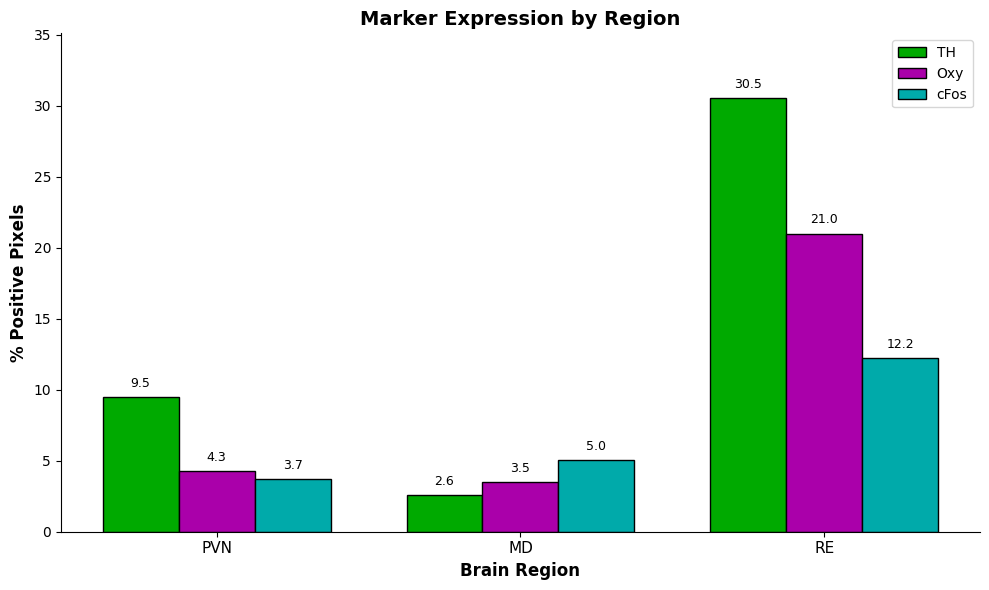

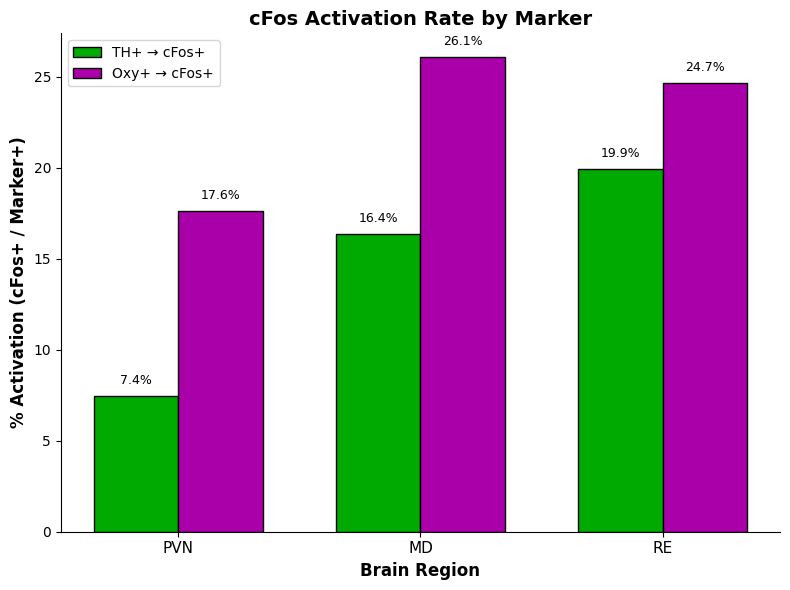

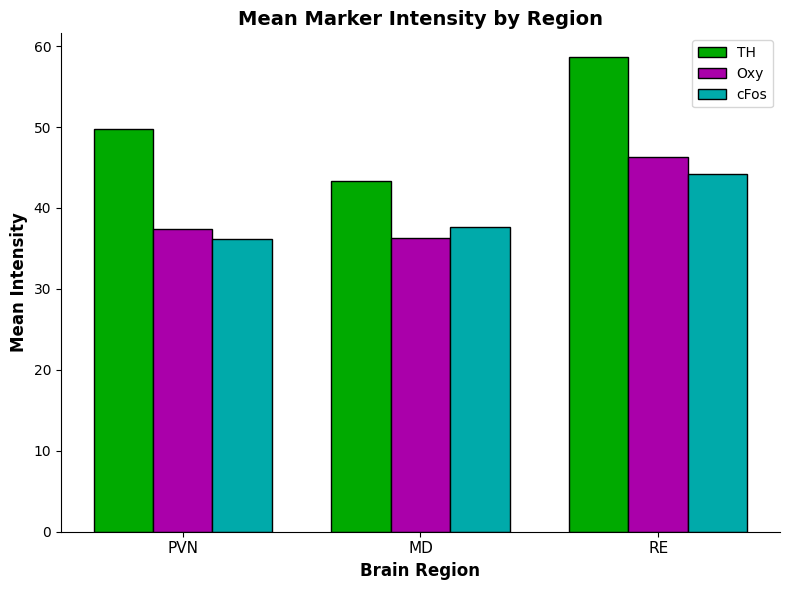

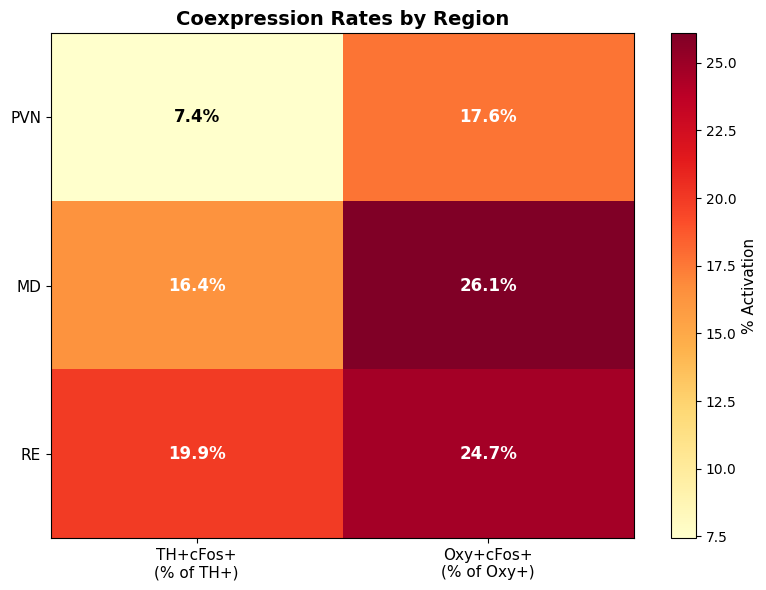

\n✓ Generated presentation figures:
  - fig_expression_by_region.png/svg
  - fig_activation_rate.png/svg
  - fig_mean_intensity.png/svg
  - fig_coexpression_heatmap.png/svg


In [7]:
# =============================================================================
# PRESENTATION CELL - Run this after saving for publication-style figures
# =============================================================================

# Run this cell after save_results() to generate presentation-style figures

def generate_presentation_figures():
    '''Generate clean, publication-ready figures'''
    
    th_thresh = current_state['th_thresh']
    oxy_thresh = current_state['oxy_thresh']
    cfos_thresh = current_state['cfos_thresh']
    
    # Calculate all stats
    stats = {}
    for region in REGION_ORDER + ['All']:
        vals_th = intensities[region]['TH']
        vals_oxy = intensities[region]['Oxy']
        vals_cfos = intensities[region]['cFos']
        
        th_pos = vals_th > th_thresh
        oxy_pos = vals_oxy > oxy_thresh
        cfos_pos = vals_cfos > cfos_thresh
        
        n = len(vals_th)
        stats[region] = {
            'n': n,
            'TH_pct': th_pos.sum() / n * 100,
            'Oxy_pct': oxy_pos.sum() / n * 100,
            'cFos_pct': cfos_pos.sum() / n * 100,
            'TH_cFos': (th_pos & cfos_pos).sum(),
            'Oxy_cFos': (oxy_pos & cfos_pos).sum(),
            'TH_cFos_rate': (th_pos & cfos_pos).sum() / th_pos.sum() * 100 if th_pos.sum() > 0 else 0,
            'Oxy_cFos_rate': (oxy_pos & cfos_pos).sum() / oxy_pos.sum() * 100 if oxy_pos.sum() > 0 else 0,
            'TH_mean': vals_th.mean(),
            'Oxy_mean': vals_oxy.mean(),
            'cFos_mean': vals_cfos.mean(),
        }
    
    # =========================================================================
    # FIGURE A: Expression by Region (clean bar chart)
    # =========================================================================
    fig_a, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(REGION_ORDER))
    width = 0.25
    
    for i, (marker, color) in enumerate([('TH', '#00AA00'), ('Oxy', '#AA00AA'), ('cFos', '#00AAAA')]):
        pcts = [stats[r][f'{marker}_pct'] for r in REGION_ORDER]
        bars = ax.bar(x + i*width, pcts, width, label=marker, color=color, edgecolor='black', linewidth=1)
        
        # Add value labels
        for bar, pct in zip(bars, pcts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{pct:.1f}', 
                    ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Brain Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('% Positive Pixels', fontsize=12, fontweight='bold')
    ax.set_title('Marker Expression by Region', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(REGION_ORDER, fontsize=11)
    ax.legend(fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, max([stats[r]['TH_pct'] for r in REGION_ORDER] + 
                       [stats[r]['Oxy_pct'] for r in REGION_ORDER] +
                       [stats[r]['cFos_pct'] for r in REGION_ORDER]) * 1.15)
    
    plt.tight_layout()
    plt.savefig('fig_expression_by_region.png', dpi=300, bbox_inches='tight')
    plt.savefig('fig_expression_by_region.svg', bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # FIGURE B: cFos Activation Rate
    # =========================================================================
    fig_b, ax = plt.subplots(figsize=(8, 6))
    
    x = np.arange(len(REGION_ORDER))
    width = 0.35
    
    th_rates = [stats[r]['TH_cFos_rate'] for r in REGION_ORDER]
    oxy_rates = [stats[r]['Oxy_cFos_rate'] for r in REGION_ORDER]
    
    bars1 = ax.bar(x - width/2, th_rates, width, label='TH+ → cFos+', color='#00AA00', edgecolor='black')
    bars2 = ax.bar(x + width/2, oxy_rates, width, label='Oxy+ → cFos+', color='#AA00AA', edgecolor='black')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.5, f'{h:.1f}%', 
                    ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Brain Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('% Activation (cFos+ / Marker+)', fontsize=12, fontweight='bold')
    ax.set_title('cFos Activation Rate by Marker', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(REGION_ORDER, fontsize=11)
    ax.legend(fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('fig_activation_rate.png', dpi=300, bbox_inches='tight')
    plt.savefig('fig_activation_rate.svg', bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # FIGURE C: Mean Intensity Comparison
    # =========================================================================
    fig_c, ax = plt.subplots(figsize=(8, 6))
    
    x = np.arange(len(REGION_ORDER))
    width = 0.25
    
    for i, (marker, color) in enumerate([('TH', '#00AA00'), ('Oxy', '#AA00AA'), ('cFos', '#00AAAA')]):
        means = [stats[r][f'{marker}_mean'] for r in REGION_ORDER]
        ax.bar(x + i*width, means, width, label=marker, color=color, edgecolor='black')
    
    ax.set_xlabel('Brain Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Intensity', fontsize=12, fontweight='bold')
    ax.set_title('Mean Marker Intensity by Region', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(REGION_ORDER, fontsize=11)
    ax.legend(fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('fig_mean_intensity.png', dpi=300, bbox_inches='tight')
    plt.savefig('fig_mean_intensity.svg', bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # FIGURE D: Coexpression Heatmap
    # =========================================================================
    fig_d, ax = plt.subplots(figsize=(8, 6))
    
    # Build matrix: rows = regions, cols = coexpression types
    coexp_types = ['TH+cFos+\n(% of TH+)', 'Oxy+cFos+\n(% of Oxy+)']
    data = np.array([
        [stats[r]['TH_cFos_rate'], stats[r]['Oxy_cFos_rate']] 
        for r in REGION_ORDER
    ])
    
    im = ax.imshow(data, cmap='YlOrRd', aspect='auto')
    
    ax.set_xticks(np.arange(len(coexp_types)))
    ax.set_yticks(np.arange(len(REGION_ORDER)))
    ax.set_xticklabels(coexp_types, fontsize=11)
    ax.set_yticklabels(REGION_ORDER, fontsize=11)
    
    # Add text annotations
    for i in range(len(REGION_ORDER)):
        for j in range(len(coexp_types)):
            ax.text(j, i, f'{data[i, j]:.1f}%', ha='center', va='center', 
                   fontsize=12, fontweight='bold',
                   color='white' if data[i, j] > data.max()/2 else 'black')
    
    ax.set_title('Coexpression Rates by Region', fontsize=14, fontweight='bold')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('% Activation', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('fig_coexpression_heatmap.png', dpi=300, bbox_inches='tight')
    plt.savefig('fig_coexpression_heatmap.svg', bbox_inches='tight')
    plt.show()
    
    print("\\n✓ Generated presentation figures:")
    print("  - fig_expression_by_region.png/svg")
    print("  - fig_activation_rate.png/svg")
    print("  - fig_mean_intensity.png/svg")
    print("  - fig_coexpression_heatmap.png/svg")

# Run it!
generate_presentation_figures()
